In [1]:
# Written by Mengzhan Liufu at Yu Lab, UChicago
# to determine the number of samples in the initial period for determining threshold for online detection

# 1 Import Packages

In [2]:
import Ipynb_importer

In [4]:
import TrodesReader
# import from https://bitbucket.org/mkarlsso/trodes/src/master/ or pip install trodesnetwork
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
import emkanalysis_clc_toolkit as ct

importing Jupyter notebook from emkanalysis_clc_toolkit.ipynb


In [26]:
def online_detect(magnitude, threshold, num_wait):
    '''
    Make online detection based on a threshold determined with an initial period
    '''
    decision = [False]*(num_wait-1)
    stimulation = []
    
    for i in range(0,len(magnitude)):
        decision.append(magnitude[i]>threshold)
        current_stimulation = True
        for m in range(len(decision)-num_wait,len(decision)):
            if not decision[m]:
                current_stimulation = False
        stimulation.append(current_stimulation)
        
    return stimulation

# 2 Load Data

In [5]:
# this is the 40 min data : 20211207_E1_124311 

# Sameera's data path
# data_path_20 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt20ch1.dat'
# data_path_28 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt28ch1.dat'
# data_path_27 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt27ch1.dat'
# data_path_29 = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt29ch1.dat'
# time_path = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.timestamps.dat'

# Jhan's data path
data_path_20 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt20ch1.dat"
data_path_28 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt28ch1.dat"
data_path_27 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt27ch1.dat"
data_path_29 = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.LFP_nt29ch1.dat"
time_path = r"C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\20211207_E1_124311\20211207_E1_124311.timestamps.dat"

In [6]:
data_20 = TrodesReader.readTrodesExtractedDataFile(data_path_20)
data_28 = TrodesReader.readTrodesExtractedDataFile(data_path_28)
data_29 = TrodesReader.readTrodesExtractedDataFile(data_path_29)
time = TrodesReader.readTrodesExtractedDataFile(time_path)

<string>:69: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [7]:
data_20 = TrodesReader.readTrodesExtractedDataFile(data_path_20)
data_28 = TrodesReader.readTrodesExtractedDataFile(data_path_28)
data_29 = TrodesReader.readTrodesExtractedDataFile(data_path_29)
time = TrodesReader.readTrodesExtractedDataFile(time_path)

In [8]:
time_data = ct.convert_time(time)

In [9]:
lfp_sampling_rate = 1500
lfp_sampling_period = (1/lfp_sampling_rate)*(10**9)

sw_lower = 5
sw_upper = 15
ripple_lower = 150
ripple_upper = 250

noise_numstd = 5

In [10]:
all_data_20 = data_20['data']
all_data_28 = data_28['data']
all_data_29 = data_28['data']
lfp_data_20 = []
lfp_data_28 = []
lfp_data_29 = []
for i in all_data_20:
    lfp_data_20.append(i[0])
for i in all_data_28:
    lfp_data_28.append(i[0])
for i in all_data_29:
    lfp_data_29.append(i[0])

In [11]:
ripple_lfp_data_20 = ct.bandpass_filter('butterworth', lfp_data_20, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
ripple_lfp_data_28 = ct.bandpass_filter('butterworth', lfp_data_28, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
ripple_lfp_data_29 = ct.bandpass_filter('butterworth', lfp_data_29, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
noise_data_20 = ct.bandpass_filter('butterworth', lfp_data_20, lfp_sampling_rate, 1, 500, 600)
noise_data_28 = ct.bandpass_filter('butterworth', lfp_data_28, lfp_sampling_rate, 1, 500, 600)
noise_data_29 = ct.bandpass_filter('butterworth', lfp_data_29, lfp_sampling_rate, 1, 500, 600)

# 3 Hilbert Processing

In [12]:
offline_hilbert_magnitude_28 = ct.hilbert_processing(ripple_lfp_data_28)
noise_hilbert_magnitude_28 = ct.hilbert_processing(noise_data_28)

In [13]:
offline_hilbert_magnitude_channelavg = ct.hilbert_processing(ripple_lfp_data_20, ripple_lfp_data_28, ripple_lfp_data_29)
noise_hilbert_magnitude_channelavg = ct.hilbert_processing(noise_data_20, noise_data_28, noise_data_29)

In [14]:
noise_hilbert_decarr_28 = ct.detect(noise_hilbert_magnitude_28, noise_numstd, 1)

In [15]:
noise_hilbert_decarr_channelavg = ct.detect(noise_hilbert_magnitude_channelavg, noise_numstd, 1)

In [18]:
offline_hilbert_denoised_results_28 = ct.denoise(offline_hilbert_magnitude_28, time_data,\
                                                         noise_hilbert_decarr_28, 1000)
offline_hilbert_denoised_28 = offline_hilbert_denoised_results_28[0]
offline_hilbert_time_28 = offline_hilbert_denoised_results_28[1]

In [19]:
offline_hilbert_denoised_results_channelavg = ct.denoise(offline_hilbert_magnitude_channelavg, time_data,\
                                                         noise_hilbert_decarr_28, 1000)
offline_hilbert_denoised_channelavg = offline_hilbert_denoised_results_channelavg[0]
offline_hilbert_time_channelavg = offline_hilbert_denoised_results_channelavg[1]

# 4 Online RMS Processing

In [22]:
online_rms_results_28 = ct.online_rms_processing(1500, time_data, 150, ripple_lower, ripple_upper, 300, lfp_data_28)
online_rms_magnitude_28 = online_rms_results_28[0]
online_rms_time_28 = online_rms_results_28[1]

In [23]:
online_rms_results_channelavg = ct.online_rms_processing(1500, time_data,150, ripple_lower, ripple_upper,\
                                                         300, lfp_data_20, lfp_data_28, lfp_data_29)
online_rms_magnitude_channelavg = online_rms_results_channelavg[0]
online_rms_time_channelavg = online_rms_results_channelavg[1]

# 5 Simulation

## 5.1 Simulate with One Channel

In [31]:
# hyperparameter test with channel 28 only
accuracy_matrix_28 = np.zeros((10,10),dtype=float)
precision_matrix_28 = np.zeros((10,10),dtype=float)
miss_matrix_28 = np.zeros((10,10),dtype=float)

for i in range(0,10):
    initial_period = online_rms_magnitude_28[0:(i+1)*150]
    rms_threshold = np.mean(initial_period)+3*np.std(initial_period)
    rms_stimarr_28 = online_detect(online_rms_magnitude_28, rms_threshold, 15)
    rms_events_28 = ct.extract_events(rms_stimarr_28, online_rms_time_28)
    rms_raw_28 = rms_events_28[2]
    
    hilbert_num_std = 4
    for j in range(0,10):
        hilbert_stimarr_28 = ct.detect(offline_hilbert_denoised_28, hilbert_num_std, 3)
        hilbert_events_28 = ct.extract_events(hilbert_stimarr_28, offline_hilbert_time_28)
        hilbert_deblipped_28 = ct.deblip_with_frequency(hilbert_events_28[2], 0.1)
        ap_results_28 = ct.accuracy_precision_calculation(rms_raw_28, hilbert_deblipped_28, 0.03)
        hilbert_num_std += 1
    
        accuracy_matrix_28[i,j] = ap_results_28[0]
        precision_matrix_28[i,j] = ap_results_28[1]
        miss_matrix_28[i,j] = ap_results_28[2]

<IPython.core.display.Javascript object>


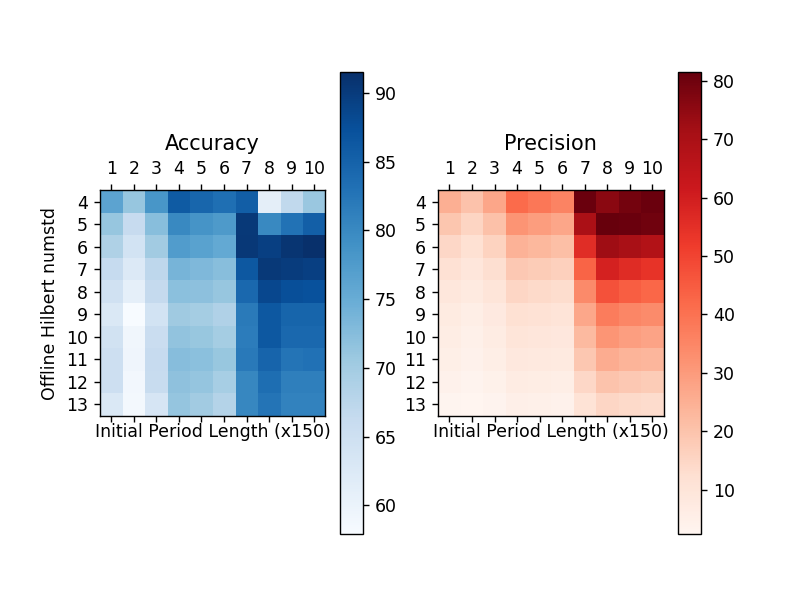

In [32]:
# Data from channel 28
%matplotlib notebook
fig,(ax1,ax2) = plt.subplots(1,2)

ax_ylabels = []
ax_xlabels = []
for i in range(0,10):
    ax_xlabels.append(str(i+1))
    ax_ylabels.append(str(i+4))
    
ax1_mat = ax1.matshow(np.transpose(accuracy_matrix_28), cmap=plt.cm.Blues)  
ax1.set_yticks(np.linspace(0,9,10))
ax1.set_yticklabels(ax_ylabels)
ax1.set_xticks(np.linspace(0,9,10))
ax1.set_xticklabels(ax_xlabels)
ax1.set_xlabel('Initial Period Length (x150)')
ax1.set_ylabel('Offline Hilbert numstd')
ax1.set_title('Accuracy')

ax2_mat = ax2.matshow(np.transpose(precision_matrix_28), cmap=plt.cm.Reds)
ax2.set_yticks(np.linspace(0,9,10)) 
ax2.set_yticklabels(ax_ylabels)
ax2.set_xticks(np.linspace(0,9,10))
ax2.set_xticklabels(ax_xlabels)
ax2.set_xlabel('Initial Period Length (x150)')
ax2.set_title('Precision')

fig.colorbar(ax1_mat,ax=ax1)
fig.colorbar(ax2_mat,ax=ax2)

## 5.2 Simulate with Multiple Channels

In [34]:
# hyperparameter test with three channels considered
accuracy_matrix_channelavg = np.zeros((10,10),dtype=float)
precision_matrix_channelavg = np.zeros((10,10),dtype=float)
miss_matrix_channelavg = np.zeros((10,10),dtype=float)

for i in range(0,10):
    initial_period = online_rms_magnitude_channelavg[0:(i+1)*150]
    rms_threshold = np.mean(initial_period)+3*np.std(initial_period)
    rms_stimarr_channelavg = online_detect(online_rms_magnitude_channelavg, rms_threshold, 15)
    rms_events_channelavg = ct.extract_events(rms_stimarr_channelavg,online_rms_time_channelavg)
    rms_raw_channelavg = rms_events_channelavg[2]
    
    hilbert_num_std = 4
    for j in range(0,10):
        hilbert_stimarr_channelavg = ct.detect(offline_hilbert_denoised_channelavg, hilbert_num_std, 3)
        hilbert_events_channelavg = ct.extract_events(hilbert_stimarr_channelavg, offline_hilbert_time_channelavg)
        hilbert_deblipped_channelavg = ct.deblip_with_frequency(hilbert_events_channelavg[2], 0.1)
        ap_results_channelavg = ct.accuracy_precision_calculation(rms_raw_channelavg, hilbert_deblipped_channelavg, 0.03)
        hilbert_num_std += 1
        
        accuracy_matrix_channelavg[i,j] = ap_results_channelavg[0]
        precision_matrix_channelavg[i,j] = ap_results_channelavg[1]
        miss_matrix_channelavg[i,j] = ap_results_channelavg[2]

<IPython.core.display.Javascript object>


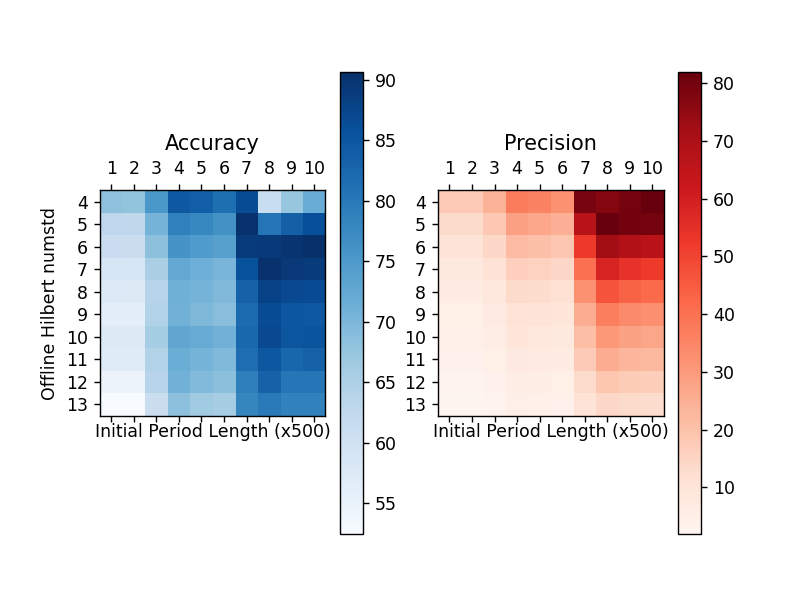

In [35]:
# Data from multiple channels
%matplotlib notebook
fig,(ax3,ax4) = plt.subplots(1,2)
    
ax3_mat = ax3.matshow(np.transpose(accuracy_matrix_channelavg), cmap=plt.cm.Blues)  
ax3.set_yticks(np.linspace(0,9,10))
ax3.set_yticklabels(ax_ylabels)
ax3.set_xticks(np.linspace(0,9,10))
ax3.set_xticklabels(ax_xlabels)
ax3.set_xlabel('Initial Period Length (x500)')
ax3.set_ylabel('Offline Hilbert numstd')
ax3.set_title('Accuracy')

ax4_mat = ax4.matshow(np.transpose(precision_matrix_channelavg), cmap=plt.cm.Reds)
ax4.set_yticks(np.linspace(0,9,10)) 
ax4.set_yticklabels(ax_ylabels)
ax4.set_xticks(np.linspace(0,9,10))
ax4.set_xticklabels(ax_xlabels)
ax4.set_xlabel('Initial Period Length (x500)')
ax4.set_title('Precision')

fig.colorbar(ax3_mat,ax=ax3)
fig.colorbar(ax4_mat,ax=ax4)